# Importing libraries.

In [3]:
import numpy as np 
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif

# Importing DataSet

In [4]:
df = pd.read_csv('loan_data_2007_2014.csv')

In [5]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 100
columns = ['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'loan_status',
 'recoveries',
 'collection_recovery_fee',
 'total_rec_prncp',
 'total_pymnt_inv',
 'total_pymnt',
 'int_rate',
 'last_pymnt_amnt',
 'out_prncp',
 'out_prncp_inv',
 'total_rec_late_fee',
 'last_credit_pull_d',
 'issue_d',
 'inq_last_6mths',
 'term',
 'revol_util',
 'annual_inc',
 'dti',
 'earliest_cr_line',
 'total_rec_int',
 'total_rev_hi_lim']

# DATASET PREPROCESSING

In [6]:
list_to_drop = [x for x in df.columns if df[x].isnull().sum() == 466285]
list_to_drop1 = ['emp_title','desc','mths_since_last_major_derog','Unnamed: 0','id','member_id','title','zip_code','url','last_pymnt_d',
                 'next_pymnt_d','pymnt_plan','application_type','policy_code','sub_grade']
df.drop(list_to_drop,axis = 1,inplace = True)
df.drop(list_to_drop1,axis = 1,inplace = True)

In [7]:
df_null = pd.DataFrame(data = df , columns = [x for x in df.columns if df[x].isnull().sum() > 0])

In [8]:
df.loc[df['acc_now_delinq'] == 0, 'total_rev_hi_lim'] = 0
df.loc[df['acc_now_delinq'] == 0, 'tot_cur_bal'] = 0
df.loc[df['acc_now_delinq'] == 0, 'tot_coll_amt'] = 0

In [9]:
df['term'] = pd.to_numeric(df['term'].str.replace('months',''))

In [10]:
df['emp_length'] = df['emp_length'].apply(lambda x:str(x).replace('+ years','').replace('< ','').replace(' ','').replace('year','').replace('s',''))
df.loc[df['emp_length'] == 'nan','emp_length'] = 0
df['emp_length'] = pd.to_numeric(df['emp_length'])

In [11]:
median = ['tot_cur_bal','tot_coll_amt','acc_now_delinq','collections_12_mths_ex_med'
         ,'total_acc','revol_util','pub_rec','annual_inc']
for i in median:
    df[i] = df[i].fillna(df[i].median())
df['earliest_cr_line'] = df['earliest_cr_line'].fillna(df['earliest_cr_line'].mode()[0])

In [12]:
df['issue_d'] = pd.to_datetime(df['issue_d'],format = '%b-%y')
df['issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-05-01') - df['issue_d'])/np.timedelta64(1,'M')))
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'],format = '%b-%y')
df['earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-05-01') - df['earliest_cr_line'])/np.timedelta64(1,'M')))

df['loan_status'] = np.where(df['loan_status'].isin(['Does not meet the credit policy. Status:Charged Off',
                                                     'Default','Charged Off','Late (31-120 days)']),0,1)
df['last_credit_pull_d'].fillna(df['last_credit_pull_d'].mode()[0],inplace = True)
df['mths_since_last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'],format = '%b-%y')
df['mths_since_last_credit_pull_d'] = round(pd.to_numeric((pd.to_datetime('2017-05-01') - df['mths_since_last_credit_pull_d'])/np.timedelta64(1,'M')))
df.fillna(0,inplace = True)

# Creating WoE and IV function for discreate var.

In [13]:
def woe_discrete(df1,variable,target):
    df1 = pd.concat([df1[variable], df[target]], axis = 1)
    df1 = pd.concat([df1.groupby(df1.columns.values[0])[df1.columns.values[1]].count(),
                     (1 - df1.groupby(df1.columns.values[0])[df1.columns.values[1]].mean())],axis =1)
    df1.columns = ['n_obs','prop_good']
    df1['prop_n_obs'] = df1['n_obs']/df1['n_obs'].sum()
    df1['n_good'] = df1['prop_good'] * df1['n_obs']
    df1['n_bad'] = (1-df1['prop_good']) * df1['n_obs']
    df1['prop_n_good'] = df1['n_good'] / df1['n_good'].sum()
    df1['prop_n_bad'] = df1['n_bad'] / df1['n_bad'].sum()
    df1['WoE'] = np.log(df1['prop_n_good']/df1['prop_n_bad'])
    df1 = df1.sort_values(['WoE'])
    df1 = df1.reset_index(drop = False)
    df1['IV'] = (df1['prop_n_good'] - df1['prop_n_bad'])*df1['WoE']
    df1['IV'] = df1['IV'].sum()
    return df1

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
def plot_woe(df,rotation = 0):
    x = np.array(df.iloc[:,0].apply(str))
    y = df['WoE']
    plt.figure(figsize=(18,6))
    plt.plot(x,y,marker = 'o',linestyle = '--',color = 'k')
    plt.xlabel(df.columns[0])
    plt.ylabel('WoE')
    plt.xticks(rotation = rotation)

#  Creating WoE and IV function for discreate var.

In [15]:
def woe_continious(df1,variable,target):
    df1 = pd.concat([df1[variable], df[target]], axis = 1)
    df1 = pd.concat([df1.groupby(df1.columns.values[0])[df1.columns.values[1]].count(),
                     (1 - df1.groupby(df1.columns.values[0])[df1.columns.values[1]].mean())],axis =1)
    df1.columns = ['n_obs','prop_good']
    df1['prop_n_obs'] = df1['n_obs']/df1['n_obs'].sum()
    df1['n_good'] = df1['prop_good'] * df1['n_obs']
    df1['n_bad'] = (1-df1['prop_good']) * df1['n_obs']
    df1['prop_n_good'] = df1['n_good'] / df1['n_good'].sum()
    df1['prop_n_bad'] = df1['n_bad'] / df1['n_bad'].sum()
    df1['WoE'] = np.log(df1['prop_n_good']/df1['prop_n_bad'])
    #df1 = df1.sort_values(['WoE'])
    df1 = df1.reset_index(drop = False)
    df1['IV'] = (df1['prop_n_good'] - df1['prop_n_bad'])*df1['WoE']
    df1['IV'] = df1['IV'].sum()
    return df1

# Using chi2 for dicrete variables and ANOVA for continious variables 

In [16]:
chi2_check = {}
X_train_cat = pd.DataFrame(data = df , columns = df.columns[df.dtypes == 'O'])
for i in X_train_cat:
        chi, p, dof, ex = chi2_contingency(pd.crosstab(df['loan_status'], df[i]))
        chi2_check.setdefault('Feature',[]).append(i)
        chi2_check.setdefault('p-value',[]).append(round(p,10))
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,grade,0.0
1,home_ownership,0.0
2,verification_status,0.0
3,purpose,0.0
4,addr_state,0.0
5,initial_list_status,0.0
6,last_credit_pull_d,0.0


In [17]:
X_train_num = pd.DataFrame(data = df,columns = df.columns[df.dtypes != 'O'])
X_train_num.fillna(X_train_num.mean(), inplace = True)
F_statistic, p_values = f_classif(X_train_num, df['loan_status'])
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

/home/nichita_novitchii/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


,Numerical_Feature,F-Score,p values
0,loan_status,inf,0.000000e+00
1,recoveries,1.126855e+05,0.000000e+00
2,collection_recovery_fee,4.585533e+04,0.000000e+00
3,total_rec_prncp,3.212344e+04,0.000000e+00
4,total_pymnt_inv,1.846452e+04,0.000000e+00
5,total_pymnt,1.832094e+04,0.000000e+00
6,int_rate,1.427656e+04,0.000000e+00
7,last_pymnt_amnt,1.354750e+04,0.000000e+00
8,out_prncp,1.204331e+04,0.000000e+00
9,out_prncp_inv,1.204120e+04,0.000000e+00


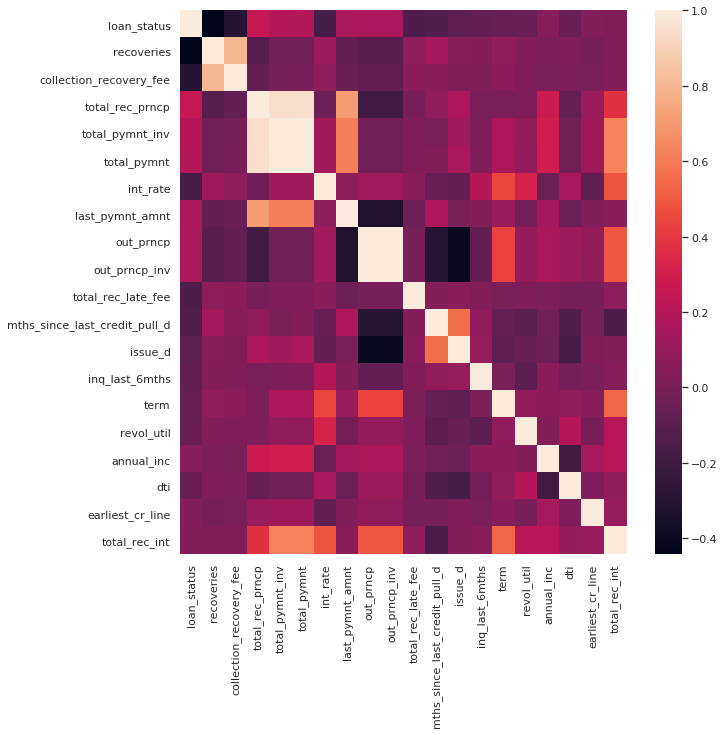

In [18]:
top_num =ANOVA_F_table.iloc[:20,0].to_list()
corr = X_train_num[top_num].corr()
#corr.sort_values()
plt.figure(figsize=(10,10))
sns.heatmap(corr);


# Creating final dataframe

In [19]:
df = pd.concat([df[chi2_result.iloc[:5,0].to_list()],df[ANOVA_F_table.iloc[:20,0].to_list()],df['total_rev_hi_lim']],axis = 1)

In [20]:
obj_df = pd.DataFrame(data = df , columns = df.columns[df.dtypes == 'O'])
obj_df = pd.get_dummies(obj_df,prefix_sep = ':')
X = pd.concat([obj_df,df.iloc[:,4:26],df['loan_status']],axis =1)

In [21]:
        X_new = X.loc[:, 'grade:A': 'grade:G']
        X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
        X_new['home_ownership:MORTGAGE'] = X.loc[:,'home_ownership:MORTGAGE']
        X_new['home_ownership:OTHER_NONE_RENT'] = sum([X['home_ownership:OTHER'], X['home_ownership:NONE'], X['home_ownership:RENT']])
        X_new = pd.concat([X_new, X.loc[:, 'verification_status:Not Verified':'verification_status:Verified']], axis = 1)
        X_new['purpose:debt_consolidation'] = X.loc[:,'purpose:debt_consolidation']
        X_new['purpose:credit_card'] = X.loc[:,'purpose:credit_card']
        X_new['purpose:major_purch__car__home_impr'] = sum([X['purpose:major_purchase'], X['purpose:car'], X['purpose:home_improvement']])
        X_new['purpose:educ__ren_en__sm_b__mov'] = sum([X['purpose:educational'], X['purpose:renewable_energy'], X['purpose:small_business'], 
                                                        X['purpose:moving']])
        X_new['purpose:vacation__house__wedding__med__oth'] = sum([X['purpose:vacation'], X['purpose:house'], X['purpose:wedding'], 
                                                                   X['purpose:medical'], X['purpose:other']])
        X_new['term:36'] = np.where((X['term'] == 36), 1, 0)
        X_new['term:60'] = np.where((X['term'] == 60), 1, 0)
        X_new['int_rate:<7.071'] = np.where((X['int_rate'] <= 7.071), 1, 0)
        X_new['int_rate:7.071-10.374'] = np.where((X['int_rate'] > 7.071) & (X['int_rate'] <= 10.374), 1, 0)
        X_new['int_rate:10.374-13.676'] = np.where((X['int_rate'] > 10.374) & (X['int_rate'] <= 13.676), 1, 0)
        X_new['int_rate:13.676-15.74'] = np.where((X['int_rate'] > 13.676) & (X['int_rate'] <= 15.74), 1, 0)
        X_new['int_rate:15.74-20.281'] = np.where((X['int_rate'] > 15.74) & (X['int_rate'] <= 20.281), 1, 0)
        X_new['int_rate:>20.281'] = np.where((X['int_rate'] > 20.281), 1, 0)
        X_new['annual_inc:missing'] = np.where(X['annual_inc'].isnull(), 1, 0)
        X_new['annual_inc:<28,555'] = np.where((X['annual_inc'] <= 28555), 1, 0)
        X_new['annual_inc:28,555-37,440'] = np.where((X['annual_inc'] > 28555) & (X['annual_inc'] <= 37440), 1, 0)
        X_new['annual_inc:37,440-61,137'] = np.where((X['annual_inc'] > 37440) & (X['annual_inc'] <= 61137), 1, 0)
        X_new['annual_inc:61,137-81,872'] = np.where((X['annual_inc'] > 61137) & (X['annual_inc'] <= 81872), 1, 0)
        X_new['annual_inc:81,872-102,606'] = np.where((X['annual_inc'] > 81872) & (X['annual_inc'] <= 102606), 1, 0)
        X_new['annual_inc:102,606-120,379'] = np.where((X['annual_inc'] > 102606) & (X['annual_inc'] <= 120379), 1, 0)
        X_new['annual_inc:120,379-150,000'] = np.where((X['annual_inc'] > 120379) & (X['annual_inc'] <= 150000), 1, 0)
        X_new['annual_inc:>150K'] = np.where((X['annual_inc'] > 150000), 1, 0)
        X_new['dti:<=1.6'] = np.where((X['dti'] <= 1.6), 1, 0)
        X_new['dti:1.6-5.599'] = np.where((X['dti'] > 1.6) & (X['dti'] <= 5.599), 1, 0)
        X_new['dti:5.599-10.397'] = np.where((X['dti'] > 5.599) & (X['dti'] <= 10.397), 1, 0)
        X_new['dti:10.397-15.196'] = np.where((X['dti'] > 10.397) & (X['dti'] <= 15.196), 1, 0)
        X_new['dti:15.196-19.195'] = np.where((X['dti'] > 15.196) & (X['dti'] <= 19.195), 1, 0)
        X_new['dti:19.195-24.794'] = np.where((X['dti'] > 19.195) & (X['dti'] <= 24.794), 1, 0)
        X_new['dti:24.794-35.191'] = np.where((X['dti'] > 24.794) & (X['dti'] <= 35.191), 1, 0)
        X_new['dti:>35.191'] = np.where((X['dti'] > 35.191), 1, 0)
        X_new['inq_last_6mths:missing'] = np.where(X['inq_last_6mths'].isnull(), 1, 0)
        X_new['inq_last_6mths:0'] = np.where((X['inq_last_6mths'] == 0), 1, 0)
        X_new['inq_last_6mths:1-2'] = np.where((X['inq_last_6mths'] >= 1) & (X['inq_last_6mths'] <= 2), 1, 0)
        X_new['inq_last_6mths:3-4'] = np.where((X['inq_last_6mths'] >= 3) & (X['inq_last_6mths'] <= 4), 1, 0)
        X_new['inq_last_6mths:>4'] = np.where((X['inq_last_6mths'] > 4), 1, 0)
        X_new['revol_util:missing'] = np.where(X['revol_util'].isnull(), 1, 0)
        X_new['revol_util:<0.1'] = np.where((X['revol_util'] <= 0.1), 1, 0)
        X_new['revol_util:0.1-0.2'] = np.where((X['revol_util'] > 0.1) & (X['revol_util'] <= 0.2), 1, 0)
        X_new['revol_util:0.2-0.3'] = np.where((X['revol_util'] > 0.2) & (X['revol_util'] <= 0.3), 1, 0)
        X_new['revol_util:0.3-0.4'] = np.where((X['revol_util'] > 0.3) & (X['revol_util'] <= 0.4), 1, 0)
        X_new['revol_util:0.4-0.5'] = np.where((X['revol_util'] > 0.4) & (X['revol_util'] <= 0.5), 1, 0)
        X_new['revol_util:0.5-0.6'] = np.where((X['revol_util'] > 0.5) & (X['revol_util'] <= 0.6), 1, 0)
        X_new['revol_util:0.6-0.7'] = np.where((X['revol_util'] > 0.6) & (X['revol_util'] <= 0.7), 1, 0)
        X_new['revol_util:0.7-0.8'] = np.where((X['revol_util'] > 0.7) & (X['revol_util'] <= 0.8), 1, 0)
        X_new['revol_util:0.8-0.9'] = np.where((X['revol_util'] > 0.8) & (X['revol_util'] <= 0.9), 1, 0)
        X_new['revol_util:0.9-1.0'] = np.where((X['revol_util'] > 0.9) & (X['revol_util'] <= 1.0), 1, 0)
        X_new['revol_util:>1.0'] = np.where((X['revol_util'] > 1.0), 1, 0)
        X_new['out_prncp:<1,286'] = np.where((X['out_prncp'] <= 1286), 1, 0)
        X_new['out_prncp:1,286-6,432'] = np.where((X['out_prncp'] > 1286) & (X['out_prncp'] <= 6432), 1, 0)
        X_new['out_prncp:6,432-9,005'] = np.where((X['out_prncp'] > 6432) & (X['out_prncp'] <= 9005), 1, 0)
        X_new['out_prncp:9,005-10,291'] = np.where((X['out_prncp'] > 9005) & (X['out_prncp'] <= 10291), 1, 0)
        X_new['out_prncp:10,291-15,437'] = np.where((X['out_prncp'] > 10291) & (X['out_prncp'] <= 15437), 1, 0)
        X_new['out_prncp:>15,437'] = np.where((X['out_prncp'] > 15437), 1, 0)
        X_new['total_pymnt:<10,000'] = np.where((X['total_pymnt'] <= 10000), 1, 0)
        X_new['total_pymnt:10,000-15,000'] = np.where((X['total_pymnt'] > 10000) & (X['total_pymnt'] <= 15000), 1, 0)
        X_new['total_pymnt:15,000-20,000'] = np.where((X['total_pymnt'] > 15000) & (X['total_pymnt'] <= 20000), 1, 0)
        X_new['total_pymnt:20,000-25,000'] = np.where((X['total_pymnt'] > 20000) & (X['total_pymnt'] <= 25000), 1, 0)
        X_new['total_pymnt:>25,000'] = np.where((X['total_pymnt'] > 25000), 1, 0)
        X_new['total_rec_int:<1,089'] = np.where((X['total_rec_int'] <= 1089), 1, 0)
        X_new['total_rec_int:1,089-2,541'] = np.where((X['total_rec_int'] > 1089) & (X['total_rec_int'] <= 2541), 1, 0)
        X_new['total_rec_int:2,541-4,719'] = np.where((X['total_rec_int'] > 2541) & (X['total_rec_int'] <= 4719), 1, 0)
        X_new['total_rec_int:4,719-7,260'] = np.where((X['total_rec_int'] > 4719) & (X['total_rec_int'] <= 7260), 1, 0)
        X_new['total_rec_int:>7,260'] = np.where((X['total_rec_int'] > 7260), 1, 0)
        X_new['total_rev_hi_lim:missing'] = np.where(X['total_rev_hi_lim'].isnull(), 1, 0)
        X_new['total_rev_hi_lim:<6,381'] = np.where((X['total_rev_hi_lim'] <= 6381), 1, 0)
        X_new['total_rev_hi_lim:6,381-19,144'] = np.where((X['total_rev_hi_lim'] > 6381) & (X['total_rev_hi_lim'] <= 19144), 1, 0)
        X_new['total_rev_hi_lim:19,144-25,525'] = np.where((X['total_rev_hi_lim'] > 19144) & (X['total_rev_hi_lim'] <= 25525), 1, 0)
        X_new['total_rev_hi_lim:25,525-35,097'] = np.where((X['total_rev_hi_lim'] > 25525) & (X['total_rev_hi_lim'] <= 35097), 1, 0)
        X_new['total_rev_hi_lim:35,097-54,241'] = np.where((X['total_rev_hi_lim'] > 35097) & (X['total_rev_hi_lim'] <= 54241), 1, 0)
        X_new['total_rev_hi_lim:54,241-79,780'] = np.where((X['total_rev_hi_lim'] > 54241) & (X['total_rev_hi_lim'] <= 79780), 1, 0)
        X_new['total_rev_hi_lim:>79,780'] = np.where((X['total_rev_hi_lim'] > 79780), 1, 0)
        X_new['mths_since_earliest_cr_line:missing'] = np.where(X['earliest_cr_line'].isnull(), 1, 0)
        X_new['mths_since_earliest_cr_line:<125'] = np.where((X['earliest_cr_line'] <= 125), 1, 0)
        X_new['mths_since_earliest_cr_line:125-167'] = np.where((X['earliest_cr_line'] > 125) & (X['earliest_cr_line'] <= 167), 1, 0)
        X_new['mths_since_earliest_cr_line:167-249'] = np.where((X['earliest_cr_line'] > 167) & (X['earliest_cr_line'] <= 249), 1, 0)
        X_new['mths_since_earliest_cr_line:249-331'] = np.where((X['earliest_cr_line'] > 249) & (X['earliest_cr_line'] <= 331), 1, 0)
        X_new['mths_since_earliest_cr_line:331-434'] = np.where((X['earliest_cr_line'] > 331) & (X['earliest_cr_line'] <= 434), 1, 0)
        X_new['mths_since_earliest_cr_line:>434'] = np.where((X['earliest_cr_line'] > 434), 1, 0)
        X_new['mths_since_issue_d:<79'] = np.where((X['issue_d'] <= 79), 1, 0)
        X_new['mths_since_issue_d:79-89'] = np.where((X['issue_d'] > 79) & (X['issue_d'] <= 89), 1, 0)
        X_new['mths_since_issue_d:89-100'] = np.where((X['issue_d'] > 89) & (X['issue_d'] <= 100), 1, 0)
        X_new['mths_since_issue_d:100-122'] = np.where((X['issue_d'] > 100) & (X['issue_d'] <= 122), 1, 0)
        X_new['mths_since_issue_d:>122'] = np.where((X['issue_d'] > 122), 1, 0)
        X_new['mths_since_last_credit_pull_d:missing'] = np.where(X['mths_since_last_credit_pull_d'].isnull(), 1, 0)
        X_new['mths_since_last_credit_pull_d:<56'] = np.where((X['mths_since_last_credit_pull_d'] <= 56), 1, 0)
        X_new['mths_since_last_credit_pull_d:56-61'] = np.where((X['mths_since_last_credit_pull_d'] > 56) & (X['mths_since_last_credit_pull_d'] <= 61), 1, 0)
        X_new['mths_since_last_credit_pull_d:61-75'] = np.where((X['mths_since_last_credit_pull_d'] > 61) & (X['mths_since_last_credit_pull_d'] <= 75), 1, 0)
        X_new['mths_since_last_credit_pull_d:>75'] = np.where((X['mths_since_last_credit_pull_d'] > 75), 1, 0)
        X_new = pd.concat([df['loan_status'],X_new],axis = 1)

In [22]:
ref_categories = ['mths_since_last_credit_pull_d:>75', 'mths_since_issue_d:>122', 'mths_since_earliest_cr_line:>434', 'total_rev_hi_lim:>79,780', 
                  'total_rec_int:>7,260', 'total_pymnt:>25,000', 'out_prncp:>15,437', 'revol_util:>1.0', 'inq_last_6mths:>4', 'dti:>35.191', 
                  'annual_inc:>150K', 'int_rate:>20.281', 'term:60', 'purpose:major_purch__car__home_impr', 'verification_status:Not Verified', 
                  'home_ownership:MORTGAGE', 'grade:G']
X_new.drop(columns = ref_categories,axis = 1, inplace = True)

# PD model creation

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split , RepeatedStratifiedKFold , cross_val_score , RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix , f1_score ,roc_auc_score ,classification_report , roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc


In [24]:
X = X_new.drop('loan_status',axis = 1)
y = X_new['loan_status']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)
model = LogisticRegression(max_iter=945, class_weight = 'balanced',penalty = 'l2',solver = 'lbfgs',C = 1000).fit(X_train,y_train)
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=1)
scores = cross_val_score(model,X_train, y_train, scoring = 'roc_auc', cv = cv)

In [25]:
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

In [26]:
AUROC , GINI

(0.8615370506404385, 0.723074101280877)

In [27]:
y_pred = model.predict(X_test)
roc_auc_score(y_test,y_pred)

0.798748976212765

# CREATING SCORECARD

In [28]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = X_train.columns.values)
summary_table['Coefficients'] = model.coef_.reshape(84,1)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', model.intercept_[0]]
summary_table.sort_index(inplace = True)

In [29]:
summary_table

,Feature name,Coefficients
0,Intercept,2.362943
1,grade:A,0.717454
2,grade:B,0.555151
3,grade:C,0.416618
4,grade:D,0.328030
5,grade:E,0.232059
6,grade:F,0.078657
7,home_ownership:OWN,-0.029826
8,home_ownership:OTHER_NONE_RENT,-0.088940
9,verification_status:Source Verified,-0.273754


In [30]:
y_hat_test = model.predict(X_test)
y_hat_test_proba = model.predict_proba(X_test) 
y_hat_test_proba = y_hat_test_proba[: , 1]

In [31]:
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)

In [32]:
y_test_proba

,loan_status,0
0,1,0.920514
1,1,0.472964
2,1,0.981627
3,1,0.821650
4,1,0.891707
...,...,...
93252,1,0.212995
93253,1,0.674018
93254,0,0.885738
93255,1,0.959444


In [33]:
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
y_test_proba.index = X_test.index
y_test_proba

,y_test_class_actual,y_hat_test_proba
362514,1,0.920514
288564,1,0.472964
213591,1,0.981627
263083,1,0.821650
165001,1,0.891707
...,...,...
115,1,0.212995
296284,1,0.674018
61777,0,0.885738
91763,1,0.959444


In [34]:
tr = 0.5
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.08866895, 0.02059899],
       [0.19060231, 0.70012975]])

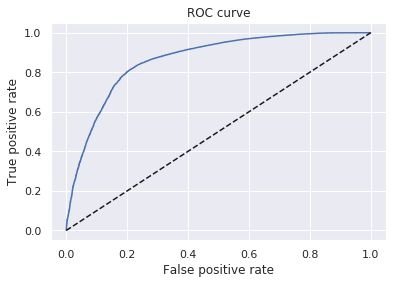

In [35]:
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [36]:
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
GINI = AUROC*2 - 1
AUROC , GINI

(0.8643317755026909, 0.7286635510053818)

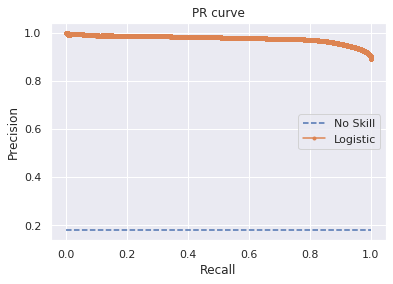

In [37]:
no_skill = len(y_test[y_test == 1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [38]:
auc_pr = auc(recall, precision)
auc_pr

0.9761019880022808

In [39]:
df_scorecard = summary_table.copy()
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]

In [40]:
min_score = 1
max_score = 751

min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,Intercept,2.362943,Intercept,398.466677,398.0
1,grade:A,0.717454,grade,30.112390,30.0
2,grade:B,0.555151,grade,23.300325,23.0
3,grade:C,0.416618,grade,17.485968,17.0
4,grade:D,0.328030,grade,13.767810,14.0
5,grade:E,0.232059,grade,9.739794,10.0
6,grade:F,0.078657,grade,3.301334,3.0
7,home_ownership:OWN,-0.029826,home_ownership,-1.251852,-1.0
8,home_ownership:OTHER_NONE_RENT,-0.088940,home_ownership,-3.732910,-4.0
9,verification_status:Source Verified,-0.273754,verification_status,-11.489789,-11.0


In [41]:
df_scorecard.loc[0, 'Score - Calculation']

398.4666773880219

In [42]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

1.0
749.0


In [43]:
score_card = df_scorecard.iloc[:,[0,4]]

In [44]:
score_card

,Feature name,Score - Preliminary
0,Intercept,398.0
1,grade:A,30.0
2,grade:B,23.0
3,grade:C,17.0
4,grade:D,14.0
5,grade:E,10.0
6,grade:F,3.0
7,home_ownership:OWN,-1.0
8,home_ownership:OTHER_NONE_RENT,-4.0
9,verification_status:Source Verified,-11.0


In [45]:
X_test.insert(0, 'Intercept', 1)
y_scores = X_test.dot(score_card['Score - Preliminary'].values)

In [46]:
y_scores

362514    401.0
288564    294.0
213591    466.0
263083    363.0
165001    386.0
          ...  
115       243.0
296284    328.0
61777     383.0
91763     431.0
167512    410.0
Length: 93257, dtype: float64

# HHI TEST (Herhindahl

In [47]:
df_cutoffs = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis = 1)
df_cutoffs.columns = ['thresholds', 'fpr', 'tpr']

In [48]:
df_cutoffs.head()

,thresholds,fpr,tpr
0,0.018496,0.0,0.000000
1,0.018537,0.0,0.000012
2,0.018652,0.0,0.000626
3,0.018812,0.0,0.000650
4,0.018890,0.0,0.001830


In [49]:
df_cutoffs['thresholds'][0] = 1 - 1 / np.power(10, 16)

In [50]:
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()

In [51]:
df_cutoffs['Score'][0] = max_score

In [52]:
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()

In [53]:
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']

In [54]:
df_cutoffs

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,1.000000,0.0,0.000000,751.0,0,93257,0.000000,1.000000
1,0.018537,0.0,0.000012,133.0,93148,109,0.998831,0.001169
2,0.018652,0.0,0.000626,133.0,93147,110,0.998820,0.001180
3,0.018812,0.0,0.000650,133.0,93146,111,0.998810,0.001190
4,0.018890,0.0,0.001830,134.0,93145,112,0.998799,0.001201
...,...,...,...,...,...,...,...,...
83810,0.999364,NaN,NaN,608.0,5,93252,0.000054,0.999946
83811,0.999426,NaN,NaN,612.0,4,93253,0.000043,0.999957
83812,0.999450,NaN,NaN,614.0,3,93254,0.000032,0.999968
83813,0.999465,NaN,NaN,615.0,2,93255,0.000021,0.999979


In [55]:
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

Best Threshold: 0.276933


In [56]:
df_cutoffs.loc[df_cutoffs['thresholds'].between(0.27788,0.277890)]

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
12283,0.277882,0.212267,0.815318,259.0,79442,13815,0.851861,0.148139
12284,0.277885,0.212267,0.815414,259.0,79441,13816,0.851850,0.148150


In [57]:
###CUT OF IS 490

#df_scorecard.to_csv('df_scorecard.csv')

In [503]:
dist1= pd.concat([y_scores,y_test],axis = 1)
dist1.columns = ['Score','Status']
dist1 = distplot.reset_index(False)
dist = dist1.iloc[:,[2,3]]

In [504]:
list = [int(x) for x in np.linspace(0,750,100)]

In [505]:

for i in range(len(list)):
    if i < 99:
            a = (list[i]+list[i+1])/2
            dist.loc[dist['Score'].isin(range(list[i],list[i+1])),'Score'] = a
            i = i + 1

In [506]:
dist['Score'] = round(dist['Score'],0)

/home/nichita_novitchii/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [507]:
dist['Score'].unique()

array([405., 291., 466., 367., 390., 322., 276., 450., 458., 329., 306.,
       360., 412., 374., 223., 208., 284., 344., 488., 352., 238., 246.,
       397., 480., 299., 382., 336., 442., 261., 254., 314., 216., 420.,
       435., 162., 230., 496., 268., 170., 192., 534., 200., 428., 178.,
       556., 473., 541., 504., 185., 147., 110., 511., 518., 549., 526.,
       132., 155., 140., 117., 647., 102., 564., 572.,  94., 124., 579.,
       610.,  86., 586., 594.,  72., 617.])

<Figure size 10800x7920 with 0 Axes>

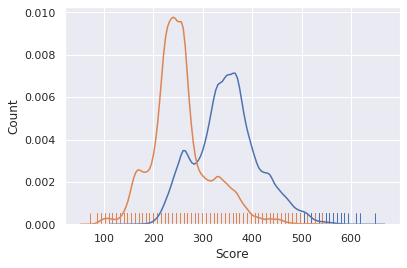

<Figure size 10800x7920 with 0 Axes>

In [508]:


unique_vals = dist['Status'].unique()  # [0, 1, 2]
targets = [dist.loc[dist['Status'] == val] for val in unique_vals]

for target in targets:
    sns.distplot(target[['Score']], hist=False, rug=True)
plt.ylabel('Count')
plt.xlabel('Score')
plt.figure(figsize=(150,110))
